In [25]:
import os
import cv2
import json
import math
import sys
import numpy as np
from pathlib import Path
from typing import Dict, List, Tuple
from matplotlib import pyplot as plt

# Add parent directory to path for utils import
sys.path.insert(0, str(Path.cwd().parent))
from utils.file_dialog_utils import pick_folder

In [ ]:
# --- USER CONFIGURATION ---

# User Inputs
screenshot_dir = Path(pick_folder(title="Select screenshots folder"))
zero_template_folder = Path(pick_folder(title="Select pocket 0 templates folder"))

GEOMETRY_JSON = "C:\\Users\\Gabriel\\Documents\\Dissertation\\Code\\notebooks\\roulette_cv2\\wheel_geometry.json"                   # produced by setup.ipynb
EVENTS_PATH = "C:\\Users\\Gabriel\\Documents\\Dissertation\\Code\\notebooks\\roulette_cv2\\inference_output2\\results_events.jsonl"  # produced by inference.ipynb

# Detection settings
MIN_ZERO_MATCH_SCORE = 0.60
PHASE_OFFSET_POCKETS = 0.0
CLOCKWISE = True

# Outputs
OUTPUT_DIR = "pocket_detection_output"
RESULTS_JSONL_PATH = os.path.join(OUTPUT_DIR, "results_events.jsonl")

# Other constants
# European Roulette wheel pocket sequence (37 pockets: 0-36)
# Starting from 0 and going clockwise
EU_WHEEL_SEQUENCE = [
    0, 32, 15, 19, 4, 21, 2, 25, 17, 34, 6, 27, 13, 36, 11, 30, 8, 23, 10,
    5, 24, 16, 33, 1, 20, 14, 31, 9, 22, 18, 29, 7, 28, 12, 35, 3, 26
]

In [27]:
# --- OUTPUT DIRECTORY SETUP ---

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print("OUTPUT_DIR:", Path(OUTPUT_DIR).resolve())

OUTPUT_DIR: C:\Users\Gabriel\Documents\Dissertation\Code\notebooks\roulette_cv2\pocket_detection_output


In [28]:
# --- DATA LOADING FUNCTIONS ---

def load_wheel_geometry(json_path: Path) -> Dict:
    """Load wheel geometry from JSON file."""
    with open(json_path, 'r') as f:
        return json.load(f)


def load_results_events(jsonl_path: Path) -> List[Dict]:
    """Load ball landing events from JSONL file."""
    events = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                events.append(json.loads(line))
    return events

In [29]:
# --- CORE ALGORITHM: COORDINATE TRANSFORMATION ---

def pixel_to_ellipse_angle(
    px: float, 
    py: float, 
    cx: float, 
    cy: float, 
    rx: float, 
    ry: float, 
    rotation_deg: float
) -> float:
    """
    Convert pixel coordinates to angle around an ellipse.
    
    Steps:
    1. Translate point to ellipse center origin
    2. Rotate to align with axis (compensate for ellipse rotation)
    3. Normalize by radii to get unit circle
    4. Compute angle using atan2
    
    Args:
        px, py: Pixel coordinates of the ball
        cx, cy: Ellipse center coordinates
        rx, ry: Ellipse radii (semi-major and semi-minor axes)
        rotation_deg: Ellipse rotation in degrees
    
    Returns:
        Angle in radians [0, 2π)
    """
    # Step 1: Translate to ellipse center
    dx = px - cx
    dy = py - cy
    
    # Step 2: Rotate to align with ellipse axes
    # Convert rotation to radians (negative because we're rotating coordinate system)
    rotation_rad = -math.radians(rotation_deg)
    cos_r = math.cos(rotation_rad)
    sin_r = math.sin(rotation_rad)
    
    # Rotate point
    x_local = dx * cos_r - dy * sin_r
    y_local = dx * sin_r + dy * cos_r
    
    # Step 3: Normalize by radii (transform ellipse to circle)
    x_norm = x_local / rx
    y_norm = y_local / ry
    
    # Step 4: Compute angle
    # atan2 returns [-π, π], convert to [0, 2π)
    angle = math.atan2(y_norm, x_norm)
    if angle < 0:
        angle += 2 * math.pi
    
    return angle


def angle_to_pocket_index(
    angle_rad: float,
    reference_angle_rad: float,
    num_pockets: int,
    clockwise: bool = True,
    phase_offset_pockets: float = 0.0,
) -> int:
    """
    Map angle to nearest pocket index (center-based), rather than floor-based binning.

    phase_offset_pockets lets you apply a constant global correction like:
      +0.0 (default)
      +0.5 (if your reference is a boundary not a center)
      -0.2 (small calibration tweak if needed)
    """
    # delta in [0, 2π)
    delta = (angle_rad - reference_angle_rad) % (2 * math.pi)

    step = (2 * math.pi) / num_pockets
    pos = delta / step  # in "pocket units"

    if not clockwise:
        pos = (num_pockets - pos) % num_pockets

    # apply optional phase correction, then round to nearest pocket center
    pos = (pos + phase_offset_pockets) % num_pockets
    pocket_idx = int((pos + 0.5)) % num_pockets  # nearest integer (center)

    return pocket_idx


def pocket_index_to_number(pocket_idx: int, wheel_sequence: List[int]) -> int:
    """Map pocket index to actual roulette number."""
    return wheel_sequence[pocket_idx % len(wheel_sequence)]

In [30]:
# --- TEMPLATE MATCHING FOR POCKET 0 ---

def load_zero_templates_from_folder(template_folder: Path) -> List[Dict]:
    """
    Load all pocket-0 templates from a folder.
    Returns list of {name, gray, w, h}.
    """
    templates = []
    for ext in ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff"):
        for path in sorted(template_folder.glob(ext)):
            img = cv2.imread(str(path))
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            h, w = gray.shape
            templates.append({
                "name": path.name,
                "gray": gray,
                "w": int(w),
                "h": int(h),
            })
    if not templates:
        raise ValueError(f"No templates found in: {template_folder}")
    return templates


def find_best_match_multi(target_gray: np.ndarray, templates: List[Dict]) -> Dict:
    """Find the best match across multiple templates."""
    best = {
        "score": -1.0,
        "location": None,
        "width": 0,
        "height": 0,
        "name": None,
    }
    for tmpl in templates:
        res = cv2.matchTemplate(target_gray, tmpl["gray"], cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val > best["score"]:
            best["score"] = float(max_val)
            best["location"] = max_loc
            best["width"] = tmpl["w"]
            best["height"] = tmpl["h"]
            best["name"] = tmpl["name"]
    return best


def reference_angle_from_zero_templates(
    screenshot_path: Path,
    templates: List[Dict],
    geometry: Dict,
    min_score: float = 0.60,
    verbose: bool = False,
    ) -> Tuple[float, Tuple[float, float], float, str, Tuple[int, int, int, int]]:
    """
    Compute the reference angle for pocket 0 using template matching.

    Returns:
      (reference_angle_rad, (zero_x, zero_y), match_score, template_name, (tlx, tly, w, h))
    """
    img = cv2.imread(str(screenshot_path))
    if img is None:
        raise ValueError(f"Could not load screenshot: {screenshot_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    match = find_best_match_multi(gray, templates)
    score = match["score"]
    if score < min_score:
        if verbose:
            print(f"Low match score for {screenshot_path.name}: {score:.3f}")
        return None, None, score, match["name"], None

    tlx, tly = match["location"]
    w, h = match["width"], match["height"]
    zero_x = tlx + w / 2.0
    zero_y = tly + h / 2.0

    ellipse = geometry["ellipse"]
    ref_angle = pixel_to_ellipse_angle(
        zero_x, zero_y,
        ellipse["cx"], ellipse["cy"],
        ellipse["rx"], ellipse["ry"],
        ellipse["rotation_deg"],
    )

    return ref_angle, (zero_x, zero_y), score, match["name"], (int(tlx), int(tly), int(w), int(h))

In [31]:
# --- VISUALIZATION FUNCTION ---

def visualize_detection(
    screenshot_path: Path,
    ball_x: float,
    ball_y: float,
    pocket_number: int,
    geometry: Dict,
    output_path: Path = None,
    zero_bbox: Tuple[int, int, int, int] = None,
    zero_center: Tuple[float, float] = None,
):
    """
    Visualize the pocket detection on the screenshot.
    
    Draws:
    - Wheel ellipse
    - Ball position
    - Detected pocket number
    - Template match location for pocket 0 (if provided)
    """
    img = cv2.imread(str(screenshot_path))
    if img is None:
        print(f"Could not load image: {screenshot_path}")
        return
    
    # Extract ellipse parameters
    ellipse = geometry['ellipse']
    cx, cy = ellipse['cx'], ellipse['cy']
    rx, ry = ellipse['rx'], ellipse['ry']
    rotation_deg = ellipse['rotation_deg']
    
    # Draw ellipse
    # cv2.ellipse(
    #     img,
    #     (int(cx), int(cy)),
    #     (int(rx), int(ry)),
    #     rotation_deg,
    #     0, 360,
    #     (0, 255, 0), 2
    # )
    
    # Draw template match box for pocket 0
    if zero_bbox is not None:
        tlx, tly, w, h = zero_bbox
        cv2.rectangle(
            img,
            (int(tlx), int(tly)),
            (int(tlx + w), int(tly + h)),
            (255, 255, 0), 2
        )
        cv2.putText(
            img,
            "Pocket 0 template",
            (int(tlx), max(int(tly) - 8, 16)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 0),
            1
        )

    # Draw detected pocket 0 center
    if zero_center is not None:
        cv2.circle(img, (int(zero_center[0]), int(zero_center[1])), 4, (255, 255, 0), -1)
    
    # Draw ball position
    cv2.circle(img, (int(ball_x), int(ball_y)), 5, (0, 0, 255), -1)
    
    # Draw line from center to ball
    cv2.line(img, (int(cx), int(cy)), (int(ball_x), int(ball_y)), 
             (255, 0, 255), 2)
    
    # Add text at top-right corner
    text = f"Pocket: {pocket_number}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    thickness = 2
    margin = 15

    (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)
    x = img.shape[1] - text_w - margin
    y = text_h + margin

    cv2.putText(img, text, (x, y), font, font_scale, (0, 255, 255), thickness)
    
    # Save if output path provided
    if output_path:
        cv2.imwrite(str(output_path), img)
    
    return img

In [32]:
geometry = load_wheel_geometry(GEOMETRY_JSON)

wheel_type = geometry['wheel']['type']
num_pockets = geometry['wheel']['pockets']
print(f"Wheel type: {wheel_type}, Pockets: {num_pockets}")
print(f"Ellipse center: ({geometry['ellipse']['cx']:.1f}, {geometry['ellipse']['cy']:.1f})")
print(f"Ellipse radii: rx={geometry['ellipse']['rx']:.1f}, ry={geometry['ellipse']['ry']:.1f}")
print(f"Ellipse rotation: {geometry['ellipse']['rotation_deg']:.2f}°")

Wheel type: EU, Pockets: 37
Ellipse center: (663.1, 344.9)
Ellipse radii: rx=223.9, ry=237.8
Ellipse rotation: 93.80°


In [33]:
# Load results events
events = load_results_events(EVENTS_PATH)

# Display events
for event in events:
    print(f"Spin {event['spin_id']}: Ball at ({event['ball']['center'][0]:.1f}, {event['ball']['center'][1]:.1f})")

Spin 1: Ball at (837.2, 437.9)
Spin 2: Ball at (666.6, 150.9)
Spin 3: Ball at (864.6, 344.3)
Spin 4: Ball at (795.2, 196.3)
Spin 5: Ball at (799.4, 200.1)
Spin 6: Ball at (747.6, 510.1)
Spin 7: Ball at (825.8, 227.4)
Spin 8: Ball at (864.7, 321.1)
Spin 9: Ball at (461.3, 322.0)
Spin 10: Ball at (760.0, 179.0)


In [34]:
zero_templates = load_zero_templates_from_folder(zero_template_folder)

# Process all landing events
print("PROCESSING LANDING EVENTS\n")

results = []

ellipse = geometry["ellipse"]
cx, cy = ellipse["cx"], ellipse["cy"]
rx, ry = ellipse["rx"], ellipse["ry"]
rotation_deg = ellipse["rotation_deg"]

for event in events:
    spin_id = event["spin_id"]
    ball_x, ball_y = event["ball"]["center"]
    screenshot_name = event["screenshot"]
    screenshot_path = screenshot_dir / screenshot_name
    
    # Find reference angle for pocket 0 in this screenshot
    reference_angle, zero_center, zero_score, zero_template_name, zero_bbox = reference_angle_from_zero_templates(
        screenshot_path,
        zero_templates,
        geometry,
        min_score=MIN_ZERO_MATCH_SCORE,
        verbose=True,
    )
    
    if reference_angle is None:
        print(f"Spin {spin_id}: pocket 0 not found (score={zero_score:.3f}), skipping")
        result = {
            "spin_id": spin_id,
            "screenshot": screenshot_name,
            "ball_position": [ball_x, ball_y],
            "pocket_index": None,
            "pocket_number": None,
            "zero_match_score": zero_score,
            "zero_template_name": zero_template_name,
            "zero_bbox": None,
        }
        results.append(result)
        print()
        continue
    
    # Calculate ball angle
    angle = pixel_to_ellipse_angle(
        ball_x, ball_y, cx, cy, rx, ry, rotation_deg
    )
    
    # Convert to pocket index
    pocket_idx = angle_to_pocket_index(
        angle, reference_angle, num_pockets,
        clockwise=CLOCKWISE,
        phase_offset_pockets=PHASE_OFFSET_POCKETS
    )
    
    # Map to pocket number
    pocket_number = pocket_index_to_number(pocket_idx, EU_WHEEL_SEQUENCE)
    
    # Store result
    result = {
        "spin_id": spin_id,
        "screenshot": screenshot_name,
        "ball_position": [ball_x, ball_y],
        "angle_rad": angle,
        "angle_deg": math.degrees(angle),
        "pocket_index": pocket_idx,
        "pocket_number": pocket_number,
        "zero_center": [zero_center[0], zero_center[1]],
        "zero_match_score": zero_score,
        "zero_template_name": zero_template_name,
        "zero_bbox": [zero_bbox[0], zero_bbox[1], zero_bbox[2], zero_bbox[3]],
        "reference_angle_rad": reference_angle,
    }
    results.append(result)
    
    print(f"Spin {spin_id}:")
    print(f"  Ball: ({ball_x:.1f}, {ball_y:.1f})")
    print(f"  Pocket 0: ({zero_center[0]:.1f}, {zero_center[1]:.1f}) score={zero_score:.3f}")
    print(f"  Template: {zero_template_name}")
    print(f"  Template box: x={zero_bbox[0]}, y={zero_bbox[1]}, w={zero_bbox[2]}, h={zero_bbox[3]}")
    print(f"  Ball Angle: {math.degrees(angle):.2f}°")
    print(f"  Pocket Index: {pocket_idx}")
    print(f"  → Pocket Number: {pocket_number}")

    # Show spin visualization with template location
    # img = visualize_detection(
    #     screenshot_path,
    #     ball_x,
    #     ball_y,
    #     pocket_number,
    #     geometry,
    #     zero_bbox=zero_bbox,
    #     zero_center=zero_center,
    # )
    # if img is not None:
    #     plt.figure(figsize=(8, 5))
    #     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #     plt.imshow(img_rgb)
    #     plt.title(f"Spin {spin_id} - Pocket {pocket_number}")
    #     plt.axis('off')
    #     plt.show()

    # print()

PROCESSING LANDING EVENTS

Spin 1:
  Ball: (837.2, 437.9)
  Pocket 0: (826.5, 185.5) score=0.929
  Template: 0number1_-040.5.png
  Template box: x=778, y=137, w=97, h=97
  Ball Angle: 295.64°
  Pocket Index: 8
  → Pocket Number: 17
Spin 2:
  Ball: (666.6, 150.9)
  Pocket 0: (719.5, 563.5) score=0.869
  Template: 0number3_+011.0.png
  Template box: x=671, y=515, w=97, h=97
  Ball Angle: 177.38°
  Pocket Index: 20
  → Pocket Number: 24
Spin 3:
  Ball: (864.6, 344.3)
  Pocket 0: (900.5, 340.5) score=0.893
  Template: 0number2_-003.0.png
  Template box: x=852, y=292, w=97, h=97
  Ball Angle: 265.78°
  Pocket Index: 0
  → Pocket Number: 0
Spin 4:
  Ball: (795.2, 196.3)
  Pocket 0: (536.5, 155.5) score=0.925
  Template: 0number1_+032.5.png
  Template box: x=488, y=107, w=97, h=97
  Ball Angle: 216.18°
  Pocket Index: 7
  → Pocket Number: 25
Spin 5:
  Ball: (799.4, 200.1)
  Pocket 0: (751.5, 139.5) score=0.954
  Template: 0number1_-019.5.png
  Template box: x=703, y=91, w=97, h=97
  Ball Angl

In [35]:
# Display results summary
print("\nResults Summary:\n")
for result in results:
    print(f"Spin {result['spin_id']}: Pocket {result['pocket_number']}")


Results Summary:

Spin 1: Pocket 17
Spin 2: Pocket 24
Spin 3: Pocket 0
Spin 4: Pocket 25
Spin 5: Pocket 15
Spin 6: Pocket 21
Spin 7: Pocket 15
Spin 8: Pocket 8
Spin 9: Pocket 3
Spin 10: Pocket 22


Results saved to: pocket_detection_output\results_events.jsonl


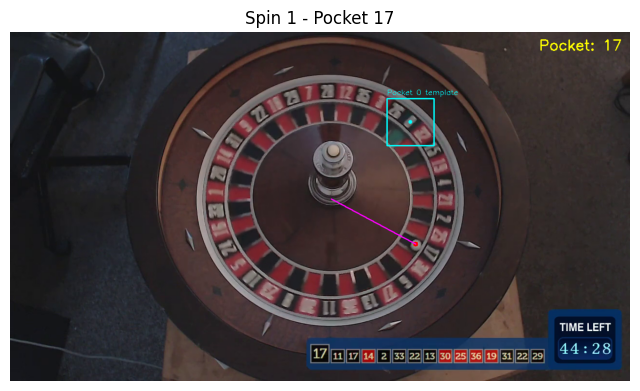

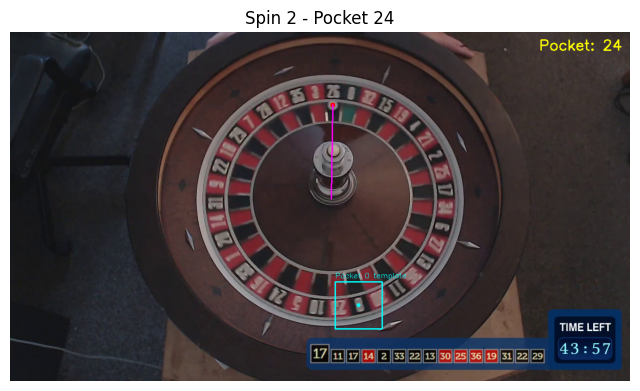

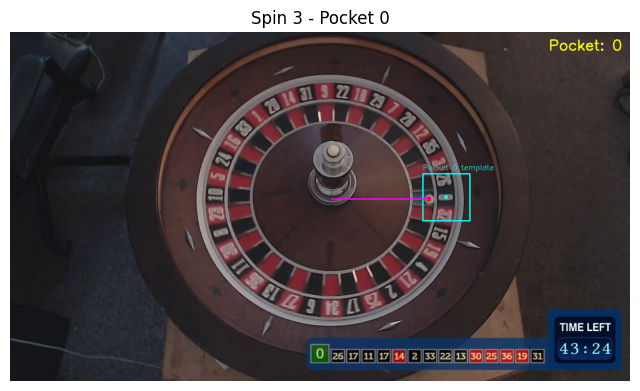

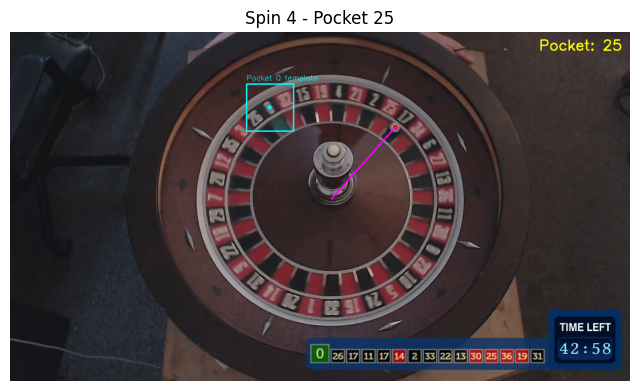

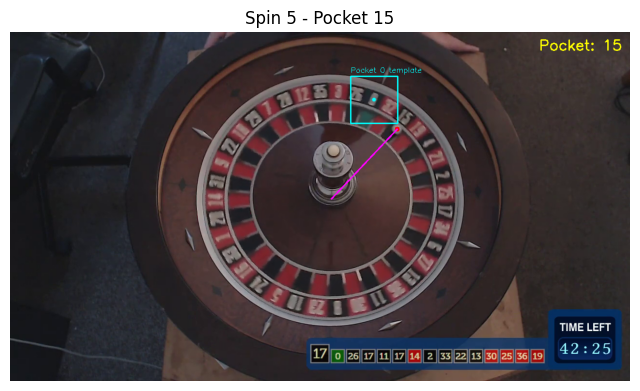

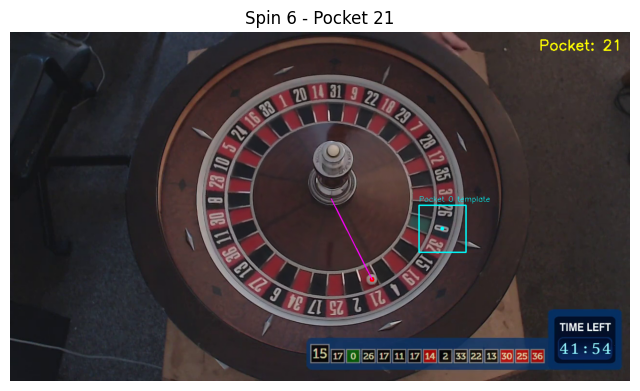

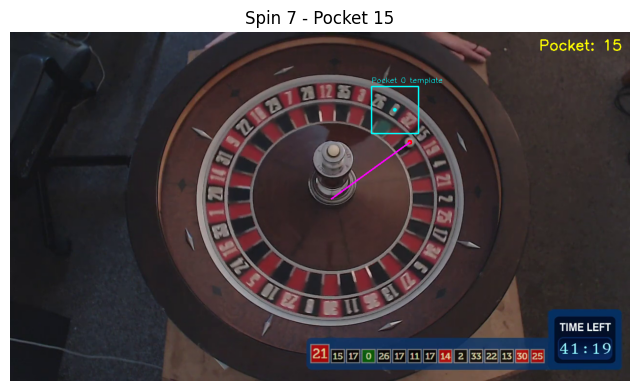

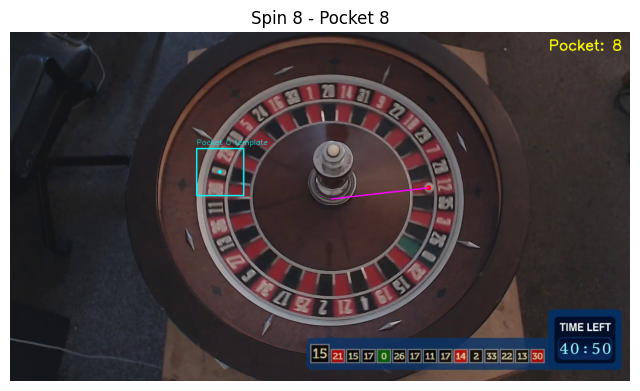

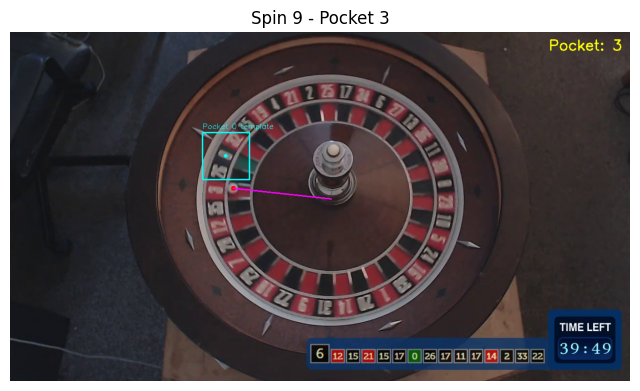

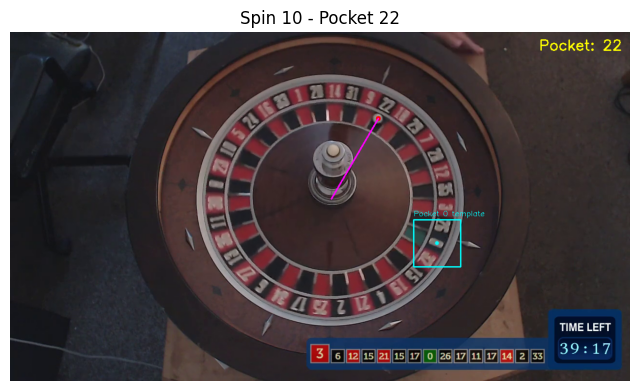

Detection screenshots saved to: C:\Users\Gabriel\Documents\Dissertation\Code\notebooks\roulette_cv2\pocket_detection_output\screenshots


In [36]:
# Save results to JSON
with open(RESULTS_JSONL_PATH, 'a', encoding="utf-8") as f:
    for event in results:
        f.write(json.dumps(event) + "\n")

print(f"Results saved to: {RESULTS_JSONL_PATH}")

# Create screenshots output directory
screenshots_output_dir = Path(OUTPUT_DIR) / "screenshots"
screenshots_output_dir.mkdir(parents=True, exist_ok=True)

# Save each detection visualization
for result in results:
    if result['pocket_number'] is None:
        continue

    screenshot_path = screenshot_dir / result['screenshot']
    output_path = screenshots_output_dir / f"pocket_{result['screenshot']}"
    
    img = visualize_detection(
        screenshot_path,
        result['ball_position'][0],
        result['ball_position'][1],
        result['pocket_number'],
        geometry,
        output_path,
        zero_bbox=tuple(result['zero_bbox']) if result.get('zero_bbox') else None,
        zero_center=tuple(result['zero_center']) if result.get('zero_center') else None,
    )

    plt.figure(figsize=(8, 5))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(f"Spin {result['spin_id']} - Pocket {result['pocket_number']}")
    plt.axis('off')
    plt.show()

print(f"Detection screenshots saved to: {screenshots_output_dir.resolve()}")